In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import os
import time

In [7]:
train_X = pd.read_csv("Oversampled_X_train.csv")
train_y = pd.read_csv("Oversampled_y_train.csv")
train_X['target'] = train_y
train_X.to_csv("train.csv",index=False)

In [8]:
val_X = pd.read_csv("X_val.csv")
val_y = pd.read_csv("y_val.csv")
val_X['target'] = val_y
val_X.to_csv("validation.csv",index=False)

In [9]:
test_X = pd.read_csv("X_test.csv")
test_y = pd.read_csv("y_test.csv")
test_X['target'] = test_y
test_X.to_csv("test.csv",index=False)

In [11]:
TRAIN_FILE = 'train.csv'
VALID_FILE = 'validation.csv'
TEST_FILE = 'test.csv'
TARGET_COLUMN = 'target' 
FEATURE_COLS = [pd.read_csv("Oversampled_X_train.csv").columns]

In [12]:
INPUT_SIZE = 100 # Number of features
HIDDEN_SIZE = 64  # Number of neurons in the hidden layer (can be tuned)
OUTPUT_SIZE = 5   # Number of classes ('Dos', 'Probe', 'R2L', 'U2R', 'normal')
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 50       # Number of training epochs (can be tuned)
PATIENCE = 5      # Early stopping patience

In [14]:
device = torch.device("mps")
print(f"Using device: {device}")

Using device: mps


In [15]:

def load_and_preprocess_data(file_path, target_col, scaler=None, label_encoder=None, fit_transform=False):
    """Loads data, separates features/target, encodes target, and scales features."""
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None, None, None, None
    
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in {file_path}.")
        
        potential_features = [col for col in df.columns if col != target_col]
        if len(potential_features) == INPUT_SIZE:
             print(f"Assuming first {INPUT_SIZE} columns are features.")
             X = df.iloc[:, :INPUT_SIZE].values
            
             potential_target = [col for col in df.columns if col not in potential_features]
             if len(potential_target) == 1:
                 target_col = potential_target[0]
                 print(f"Inferred target column: '{target_col}'")
                 y_raw = df[target_col].values
             else:
                 print("Could not reliably infer features and target. Please check CSV structure and TARGET_COLUMN name.")
                 return None, None, None, None
        else:
            print(f"Error: Cannot identify {INPUT_SIZE} feature columns.")
            return None, None, None, None

    else:
       
        feature_columns = [col for col in df.columns if col != target_col]
        if len(feature_columns) != INPUT_SIZE:
             print(f"Warning: Expected {INPUT_SIZE} feature columns, but found {len(feature_columns)} in {file_path}. Using these {len(feature_columns)} columns.")

        X = df[feature_columns].values
        y_raw = df[target_col].values

    # Encode target labels
    if fit_transform:
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y_raw)
        print("\nTarget Class Mapping:")
        for i, class_name in enumerate(label_encoder.classes_):
            print(f"{class_name}: {i}")
        print("-" * 20)
    else:
        if label_encoder is None:
             print("Error: LabelEncoder must be provided for transform-only mode.")
             return None, None, None, None
        
        y = label_encoder.transform(y_raw)


    # Scale features
    if fit_transform:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        if scaler is None:
            print("Error: Scaler must be provided for transform-only mode.")
            return None, None, None, None
        X = scaler.transform(X)

    return X, y, scaler, label_encoder

# Load Train data and fit Scaler/LabelEncoder
X_train_np, y_train_np, scaler, label_encoder = load_and_preprocess_data(
    TRAIN_FILE, TARGET_COLUMN, fit_transform=True
)
if X_train_np is None:
    exit() # Stop execution if training data failed to load

# Load Validation data using fitted Scaler/LabelEncoder
X_val_np, y_val_np, _, _ = load_and_preprocess_data(
    VALID_FILE, TARGET_COLUMN, scaler=scaler, label_encoder=label_encoder
)
if X_val_np is None:
    exit()

# Load Test data using fitted Scaler/LabelEncoder
X_test_np, y_test_np, _, _ = load_and_preprocess_data(
    TEST_FILE, TARGET_COLUMN, scaler=scaler, label_encoder=label_encoder
)
if X_test_np is None:
    exit()



Target Class Mapping:
Dos: 0
Probe: 1
R2L: 2
U2R: 3
normal: 4
--------------------


In [16]:
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.long)

In [18]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [19]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [20]:
print(f"\nData loaded successfully:")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print("-" * 20)


Data loaded successfully:
Train samples: 269365
Validation samples: 25195
Test samples: 22543
Number of features: 100
Number of classes: 5
--------------------


In [21]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [22]:
model = SimpleNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
print("Model Architecture:")
print(model)
print("-" * 20)

Model Architecture:
SimpleNN(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)
--------------------


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [25]:
from tqdm.auto import tqdm

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = 'best_model_nn.pth'

start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
    model.train()  
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    model.eval()  
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val

    print(f'Epoch [{epoch+1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if val_loss < best_val_loss:
        print(f'Validation loss decreased ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...')
        torch.save(model.state_dict(), best_model_path)
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f'Validation loss did not improve for {epochs_no_improve} epoch(s).')

    if epochs_no_improve >= PATIENCE:
        print(f'\nEarly stopping triggered after {epoch + 1} epochs.')
        break

training_time = time.time() - start_time
print(f"\nTraining finished in {training_time:.2f} seconds.")
print("-" * 20)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.0178, Train Acc: 99.58%, Val Loss: 0.0162, Val Acc: 99.56%
Validation loss decreased (inf --> 0.0162). Saving model...
Epoch [2/50], Train Loss: 0.0077, Train Acc: 99.81%, Val Loss: 0.0123, Val Acc: 99.65%
Validation loss decreased (0.0162 --> 0.0123). Saving model...
Epoch [3/50], Train Loss: 0.0055, Train Acc: 99.86%, Val Loss: 0.0103, Val Acc: 99.71%
Validation loss decreased (0.0123 --> 0.0103). Saving model...
Epoch [4/50], Train Loss: 0.0046, Train Acc: 99.88%, Val Loss: 0.0074, Val Acc: 99.76%
Validation loss decreased (0.0103 --> 0.0074). Saving model...
Epoch [5/50], Train Loss: 0.0039, Train Acc: 99.90%, Val Loss: 0.0066, Val Acc: 99.77%
Validation loss decreased (0.0074 --> 0.0066). Saving model...
Epoch [6/50], Train Loss: 0.0035, Train Acc: 99.92%, Val Loss: 0.0068, Val Acc: 99.82%
Validation loss did not improve for 1 epoch(s).
Epoch [7/50], Train Loss: 0.0030, Train Acc: 99.93%, Val Loss: 0.0050, Val Acc: 99.88%
Validation loss decreased (0.00

In [26]:
best_model = SimpleNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
try:
    best_model.load_state_dict(torch.load(best_model_path))
except FileNotFoundError:
     print(f"Warning: Best model file '{best_model_path}' not found. Evaluating with the last state.")
     
     best_model = model 

In [27]:
best_model.eval()  
test_loss = 0.0
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = 100 * correct_test / total_test

print("\n--- Test Set Evaluation Results (using best model) ---")
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')
print("-" * 20)


--- Test Set Evaluation Results (using best model) ---
Test Loss: 3.8886
Test Accuracy: 80.00%
--------------------



Classification Report:
              precision    recall  f1-score   support

         Dos       0.96      0.86      0.91      7459
       Probe       0.68      0.77      0.72      2421
         R2L       0.77      0.21      0.33      2885
         U2R       0.44      0.58      0.50        67
      normal       0.74      0.94      0.83      9711

    accuracy                           0.80     22543
   macro avg       0.72      0.67      0.66     22543
weighted avg       0.81      0.80      0.78     22543


Confusion Matrix:


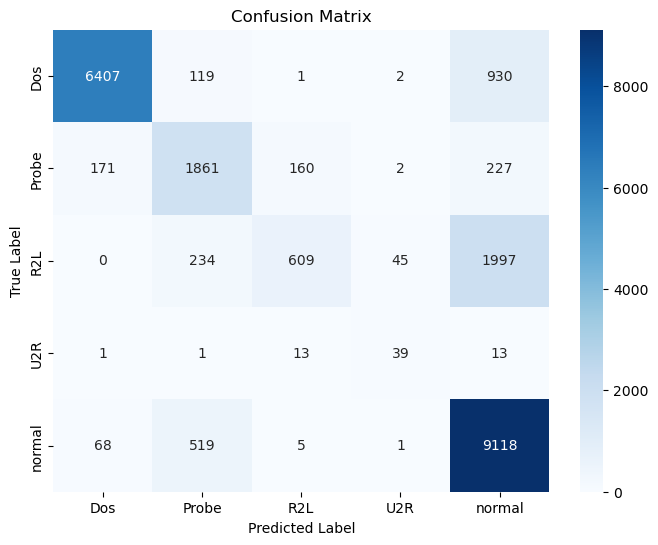

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()